# SESTM with Chinese Text
Investment Analysis with Machine Learning\
UROP 1100E (Man Yin Michael YEUNG, 2021 Fall)

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import jieba
import jieba.posseg as pseg
import paddle
import string
import re
from multiprocessing import Pool
from stopwordsiso import stopwords
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
from IPython.display import clear_output

### Retrieve Preprocessed Data

In [3]:
merged_data = pd.read_parquet('D:/michael/full_version_data/preprocessed_data_2.parquet.gzip')
merged_data.shape

(497665, 8)

In [4]:
merged_data = merged_data.drop(columns=['jieba_sentence'])

In [5]:
merged_data.head(3)

,ID,SecuCode,date,specret,specret_2d,specret_tp2-tp6,jieba_content
0,181899,600323,2010-01-04,0.006658,-0.001522,-0.030300,"[南海发展nt, 水价n, 如期t, 上调v, 增厚v, 业绩n, 约d, 事项n, 公司n..."
1,181900,002024,2010-01-04,-0.004292,-0.022783,-0.047744,"[苏宁ns, 电器n, 内外s, 兼修v, 进入v, 新一轮nz, 增长期n, 投资vn, ..."
2,181901,002092,2010-01-04,0.030815,0.018962,0.055390,"[泰ns, 化学n, 发布v, 准东ns, 井田nr, 勘探vn, 报告n, 煤炭n, 开发..."


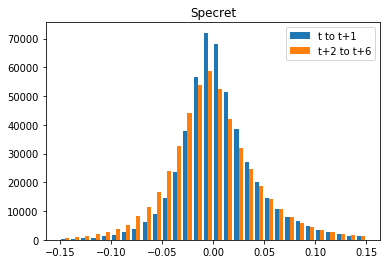

In [6]:
import matplotlib.pyplot as plt
x1 = merged_data['specret_2d']; x2 = merged_data['specret_tp2-tp6']
plt.hist([x1,x2], range=[-0.15,0.15],bins=30, label=['t to t+1', 't+2 to t+6'])
plt.title('Specret'); plt.legend(); plt.show()

### Data Splits

In [7]:
train_data = merged_data[merged_data.date <= dt.datetime(2014,12,31)]
test_data = merged_data[merged_data.date >= dt.datetime(2015,1,1)]
print(train_data.shape, test_data.shape, 'pi-hat:',len(train_data.loc[train_data['specret_2d']>0])/len(train_data))

(181035, 7) (316630, 7) pi-hat: 0.5156571933604


In [8]:
### MEMORY SAVING
del merged_data

## Count and f_j Calculation
``` DO NOT RUN THE CODES OF THIS SECTION: RESULTS ARE ARCHIVED ```

In [ ]:
MIN_KAPPA_QUANTILE = 0.90 # the minimum of KAPPA_QUANTILE's for grid search

In [ ]:
flat = [item for sublist in list(train_data.jieba_content) for item in sublist]
counter = Counter(flat)
counter_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
kappa = counter_df[counter_df.columns[1]].quantile(MIN_KAPPA_QUANTILE)
frequency_filtered_words = [x[0] for x in counter.items() if x[1] >= kappa]
print(kappa, len(frequency_filtered_words))

In [ ]:
train_data_2 = train_data[['jieba_content','specret_2d']].copy()
def get_fj_variant(word):
    global train_data_2
    train_data_2['inc_word'] = train_data_2.jieba_content.map(lambda x: word in x)
    df_word = train_data_2.loc[train_data_2.inc_word == True]
    df_word['pos_return'] = df_word['specret_2d'].map(lambda x: x>0)
    return df_word.pos_return.mean()

In [ ]:
return_dict = dict()
for ind, word in enumerate(frequency_filtered_words):
    print('Progress:\t{Count}/{Total}'.format(Count=ind,Total=len(frequency_filtered_words))); clear_output(wait=True)
    return_dict[word] = get_fj_variant(word)

In [ ]:
fj_var_df = pd.DataFrame.from_dict(return_dict, orient='index')
fj_var_df.to_csv('D:/michael/fj_variant.csv',mode='w+',encoding='utf_8_sig')

In [ ]:
flat = [item for sublist in list(train_data.jieba_content) for item in sublist]; counter = Counter(flat)
counter_df = pd.DataFrame.from_dict(counter, orient='index').reset_index(); counter_df.index = counter_df['index']
counter_df = counter_df.rename(columns={counter_df.columns[1]:'count'}); counter_df = counter_df.drop(columns=['index'])
counter_df['word_only'] = counter_df.index.map(lambda x: str(re.findall(r'[\u4e00-\u9fff]+', x))[2:-2])
counter_df['pos'] = counter_df.index.map(lambda x: str(re.findall(r'[A-z]+', x))[2:-2])
counter_df['length'] = counter_df.word_only.map(len); counter_df.head(3)

In [ ]:
counter_df.to_csv('D:/michael/jieba_content_counter_train.csv')

## Testing Model

In [9]:
def word_filter(list_0):
    ret = []
    for item in list_0:
        if item in filtered_words: ret.append(item)
    return ret

In [10]:
def likelihood_func(p, O, card_S, d, lambda_):
    sum_ = 0
    for j in range(0, len(O)):
        if p*O[j][0]+(1-p)*O[j][1]>0:
            sum_ += d[j] * np.log(p*O[j][0]+(1-p)*O[j][1])
    return (1/card_S)*sum_ + lambda_*np.log(p*(1-p))

In [11]:
def len_wise_filter(df_in):
    remove_len_pos = [
        ['w','r','ns','f','p','c','q','n','nr','m','u'],
        ['nw','u','m','t','TIME','nr','PER','nz','n','q','ORG','f','LOC','r','s'],
        ['s','r','LOC','f','ORG','nt','n','nz','PER','nr','TIME','t','m','nw'],
        ['s','LOC','f','ORG','n','nz','PER','nr','TIME','t','m','nw']    
    ]
    count_1 = df_in.loc[(df_in.length == 1) & (~df_in.pos.isin(remove_len_pos[0]))]
    count_2 = df_in.loc[(df_in.length == 2) & (~df_in.pos.isin(remove_len_pos[1]))]
    count_3 = df_in.loc[(df_in.length == 3) & (~df_in.pos.isin(remove_len_pos[2]))]
    count_4 = df_in.loc[(df_in.length >= 4) & (~df_in.pos.isin(remove_len_pos[3]))]
    return count_1.append(count_2).append(count_3).append(count_4)

In [15]:
def testing_model(train_data_used, test_data_used, kappa_quantile=0.97, alpha_word_num=50, lambda_=0.1,\
                  pos_used='av', return_col='specret_2d', train_data_restrict = False, seq=0):    
    print('TRAINING MODEL {Seq} ...'.format(Seq=seq))
    print('SPECS:\t\t{Rc}\t{Pu}\t{Awn}\t{Tdr}\t{Lamb}\t{Kq}'\
          .format(Rc=return_col,Pu=pos_used,Awn=alpha_word_num,Tdr=train_data_restrict,Lamb=lambda_,Kq=kappa_quantile))
    global filtered_words
    
    #  preparation
    from sklearn.preprocessing import normalize; from sklearn import linear_model
    from scipy.optimize import fminbound; from scipy.optimize import minimize
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(token_pattern=u"(?u)\\b\\w+\\b")  
    train_data_used = train_data_used.sort_values(by='date')
    if train_data_restrict == 'extreme':
        train_data_used = train_data_used.loc[(train_data_used[return_col] <= -0.02) | (train_data_used[return_col] >= 0.02)]  
    elif train_data_restrict:
        train_data_used = train_data_used.loc[(train_data_used[return_col] >= -0.02) & (train_data_used[return_col] <= 0.02)]
    count = pd.read_csv('D:/michael/jieba_content_counter_train.csv',index_col=0)
    kappa = int(np.ceil(count['count'].quantile(kappa_quantile)))
    fj_var_df = pd.read_csv('D:/michael/fj_variant.csv')
    fj_var_df = fj_var_df.rename(columns={fj_var_df.columns[0]: 'word',fj_var_df.columns[1]: 'fj_var'})
    fj_var_df.index = fj_var_df.word
    print('Preparation Step Done.')
    
    # select the set of sentiment charged words
    count = count.join(fj_var_df, how='inner'); count = count.drop(columns=['word'])
    if pos_used == 'av':
        count_filtered = count.loc[(count['pos']== 'a')|(count['pos']=='v')]
    elif pos_used == 'len-wise':
        count_filtered = len_wise_filter(count)
    else:
        raise ValueError('Improper pos_used!')
    print(len(count_filtered))
    count_filtered = count_filtered.sort_values(by = ['fj_var'], ascending=False)
    count_pos = count_filtered.loc[count['count']>=kappa]
    count_filtered = count_filtered.sort_values(by = ['fj_var'], ascending=True)
    count_neg = count_filtered.loc[count['count']>=kappa]
    positive_sentiment_words = list(count_pos[:alpha_word_num].index)
    negative_sentiment_words = list(count_neg[:alpha_word_num].index)
    filtered_words = positive_sentiment_words + negative_sentiment_words
    words_hash_sum = 0
    for word in filtered_words:
        words_hash_sum += hash(word)
    print('Words Selection Step Done.')
    
    # process training and testing data copies. Regression Model.
    train_data_used['jieba_content'] = train_data_used['jieba_content']\
    .map(word_filter).map(lambda x: " ".join(x))
    test_data_used['jieba_content'] = test_data_used['jieba_content']\
    .map(word_filter).map(lambda x: " ".join(x))
    train_data_used['return'] = train_data_used[return_col].rank() / len(train_data_used)
    
    D = vectorizer.fit_transform(train_data_used.append(test_data_used).jieba_content).toarray()
    D_train = D[:len(train_data_used)]; D_test = D[len(train_data_used):]
    H = normalize(D_train, norm="l1")
    W = [[x, 1-x] for x in train_data_used['return']]
    lm = linear_model.LinearRegression(fit_intercept=False); lm.fit(W,H)
    O = lm.coef_; O = O.clip(min=0); O = normalize(O.transpose(), norm="l1").transpose()
    print('Regression Model Done.')
    
    # MEMORY SAVING
    del train_data_used
    
    # MLE using SciPy
    predicted_sentiment = []; rolling_corr = None; rolling_corr_spearman = None; test_date = None
    track_corr = pd.DataFrame(columns=['date','corr','corr_spearman']); start_time = dt.datetime.now()
    for i in range(0, len(test_data_used)):
        clear_output(wait=True)
        print('TESTING MODEL {Seq} ...'.format(Seq=seq))
        print('SPECS:\t\t{Rc}\t{Pu}\t{Awn}\t{Tdr}\t{Lamb}\t{Kq}'\
              .format(Rc=return_col,Pu=pos_used,Awn=alpha_word_num,Tdr=train_data_restrict,Lamb=lambda_,Kq=kappa_quantile))
        print('Progress:\t{Count}/{Total} ({Pct}%)'\
              .format(Count=i+1,Total=len(test_data_used),Pct=round((i+1)/(len(test_data_used))*100,2)))
        if not i%100:
            test_date = test_data_used.iloc[i].date
        print('Loading Data:\t',test_date);time_now = dt.datetime.now(); print('Elasped:\t',time_now - start_time)
        print('Est. Left:\t',(time_now - start_time)/(i+1)*(len(test_data_used)-i-1))
        print('ETA:\t\t',time_now+(time_now - start_time)/(i+1)*(len(test_data_used)-i-1))
        optimal_p = fminbound(lambda p: -1*likelihood_func(p, O,len(filtered_words),D_test[i],lambda_),0,1)
        predicted_sentiment.append(optimal_p)
        if (i>1 and not i%100) or i==len(test_data_used)-1:
            test_data_segment = test_data_used[0:i+1]; test_data_segment['predicted_sentiment'] = predicted_sentiment
            rolling_corr = test_data_segment[[return_col,'predicted_sentiment']].corr(method='pearson').iloc[0]['predicted_sentiment']
            rolling_corr_spearman = test_data_segment[[return_col,'predicted_sentiment']].corr(method='spearman').iloc[0]['predicted_sentiment']
            track_corr = track_corr.append(pd.DataFrame([[test_date,rolling_corr,rolling_corr_spearman]],columns=['date','corr','corr_spearman']))
        print('Pearson:\t',rolling_corr)
        print('Spearman:\t',rolling_corr_spearman) 
    
    # COMPUTE FINAL RESULTS
    test_data_used['predicted_sentiment'] = predicted_sentiment
    test_corr = test_data_used[[return_col,'predicted_sentiment']].corr(method='pearson').iloc[0]['predicted_sentiment']
    test_corr_spearman = test_data_used[[return_col,'predicted_sentiment']].corr(method='spearman').iloc[0]['predicted_sentiment']
    
    # TESING IDENTIFIER
    testing_identifier = 'sestm_{Kq}_{Awn}_{Lamb}_{Pos}_{RetCol}_TDR={Tdr}_{WordHash}'\
    .format(WordHash=words_hash_sum%100000,Kq=kappa_quantile,Awn=alpha_word_num,\
            Lamb=lambda_,Pos=pos_used,RetCol=return_col,Tdr=str(train_data_restrict))
    
    # SAVE FILES
    track_corr.to_csv('D:/michael/full_version_data/testing_results/track_corr_{Ti}.csv'.format(Ti=testing_identifier))
    test_data_used = test_data_used.rename(columns={'predicted_sentiment':testing_identifier})
    test_data_used[['ID',testing_identifier]].to_csv('D:/michael/full_version_data/testing_results/test_data_{Ti}.csv'\
                                                        .format(Ti=testing_identifier))
                                                        
    del test_data_used
    return str(testing_identifier), int(words_hash_sum), list(positive_sentiment_words), list(negative_sentiment_words), float(test_corr), float(test_corr_spearman)

In [13]:
train_data = train_data.sort_values(by='date',ascending=True)
test_data = test_data.sort_values(by='date',ascending=True)

cols = ['seq','identifier','return_col','pos_used','alpha_word_num','train_data_retrict','lambda','kappa_quantile','test_words_hash','test_pos_words',\
        'test_neg_words','test_corr','test_corr_spearman']
pd.DataFrame(columns=cols).to_csv('D:/michael/full_version_data/testing_summary.csv')

In [17]:
cols = ['seq','identifier','return_col','pos_used','alpha_word_num','train_data_retrict','lambda','kappa_quantile','test_words_hash','test_pos_words',\
        'test_neg_words','test_corr','test_corr_spearman']

rcs = np.array(['specret_2d'])
awns = np.array([500,50])
tdrs = np.array(['extreme']) # True, False, 'extreme'
pus = np.array(['len-wise','av'])
lambs = np.array([0.1])
kqs = np.array([0.97])

from itertools import product as prod
specs = list(prod(*[rcs,awns,tdrs, pus, lambs, kqs]))
for ind, (rc, awn, tdr, pu, lamb, kq) in enumerate(specs):
    ind += 8
    ti, test_words_hash, test_pos_words, test_neg_words, test_corr, test_corr_spearman\
    = testing_model(train_data.copy(), test_data.copy(), alpha_word_num = awn, pos_used=pu,\
                    return_col=rc, train_data_restrict=tdr, lambda_=lamb, kappa_quantile=kq, seq=ind)
    print('Words Hash:\t{Hash}'.format(Hash=test_words_hash))
    summary = pd.read_csv('D:/michael/full_version_data/testing_summary.csv',index_col=0)
    summary['index'] = summary.index; summary \
    = summary.append(pd.DataFrame([[ind,ti,rc,pu,awn,tdr,lamb,kq,test_words_hash, test_pos_words, test_neg_words,\
                                    test_corr, test_corr_spearman]], columns=cols))
    summary.index = summary['index']; summary = summary.drop(columns=['index'])
    summary.to_csv('D:/michael/full_version_data/testing_summary.csv')

TESTING MODEL 11 ...
SPECS:		specret_2d	av	50	extreme	0.1	0.97
Progress:	316630/316630 (100.0%)
Loading Data:	 2021-08-19 00:00:00
Elasped:	 0:49:29.740029
Est. Left:	 0:00:00
ETA:		 2021-11-14 10:40:40.631401
Pearson:	 0.0938179004171956
Spearman:	 0.11505430717139908
Words Hash:	13327690004509275758


In [21]:
ts = pd.read_csv('D:/michael/full_version_data/testing_summary.csv',index_col=1)
ts.shape

(13, 13)

In [22]:
ts = ts.drop(columns=['index'])
ts['test_words_hash'] = ts['test_words_hash'].map(lambda x: int(x)%100000)

In [35]:
corr_p = []; corr_s = []
for index, row in ts.iterrows():
    tr = pd.read_csv('D:/michael/full_version_data/testing_results/test_data_{Ti}.csv'.format(Ti=row.identifier))[['ID',row.identifier]]
    mdf = pd.merge(tr, test_data[['ID','specret_tp2-tp6']], on='ID')
    corr_p.append(mdf[['specret_tp2-tp6',row.identifier]].corr(method='pearson').iloc[0][row.identifier])
    corr_s.append(mdf[['specret_tp2-tp6',row.identifier]].corr(method='spearman').iloc[0][row.identifier])
ts['test_corr_tp2-tp6'] = corr_p
ts['test_corr_spearman_tp2-tp6'] = corr_s
ts = ts.dropna()
ts

,identifier,return_col,pos_used,alpha_word_num,train_data_retrict,lambda,kappa_quantile,test_words_hash,test_pos_words,test_neg_words,test_corr,test_corr_spearman,test_corr_tp2-tp6,test_corr_spearman_tp2-tp6
seq,,,,,,,,,,,,,,
0,sestm_0.97_500_0.1_len-wise_specret_2d_TDR=Fal...,specret_2d,len-wise,500.0,False,0.1,0.97,9284,"['欧亚ns', '必净a', '翼ng', '峨眉山ns', '股改j', '芬太尼nrt...","['国航j', '华兰ns', '福田ns', '调低v', '中联重科j', '改增v',...",0.093270,0.110001,0.020670,0.016560
1,sestm_0.97_500_0.1_av_specret_2d_TDR=False_78786,specret_2d,av,500.0,False,0.1,0.97,78786,"['必净a', '授予v', '彰显v', '压裂v', '固废a', '可行v', '聚合...","['调低v', '改增v', '下调v', '受累v', '吞噬v', '装卸v', '贬值...",0.099000,0.114305,0.019705,0.011355
2,sestm_0.97_500_0.1_len-wise_specret_2d_TDR=Tru...,specret_2d,len-wise,500.0,True,0.1,0.97,9284,"['欧亚ns', '必净a', '翼ng', '峨眉山ns', '股改j', '芬太尼nrt...","['国航j', '华兰ns', '福田ns', '调低v', '中联重科j', '改增v',...",0.083862,0.107506,0.025947,0.018811
3,sestm_0.97_500_0.1_av_specret_2d_TDR=True_78786,specret_2d,av,500.0,True,0.1,0.97,78786,"['必净a', '授予v', '彰显v', '压裂v', '固废a', '可行v', '聚合...","['调低v', '改增v', '下调v', '受累v', '吞噬v', '装卸v', '贬值...",0.091706,0.117626,0.020369,0.012095
4,sestm_0.97_50_0.1_len-wise_specret_2d_TDR=Fals...,specret_2d,len-wise,50.0,False,0.1,0.97,5024,"['欧亚ns', '必净a', '翼ng', '峨眉山ns', '股改j', '芬太尼nrt...","['国航j', '华兰ns', '福田ns', '调低v', '中联重科j', '改增v',...",0.068118,0.092237,0.019675,0.021379
5,sestm_0.97_50_0.1_av_specret_2d_TDR=False_93151,specret_2d,av,50.0,False,0.1,0.97,93151,"['必净a', '授予v', '彰显v', '压裂v', '固废a', '可行v', '聚合...","['调低v', '改增v', '下调v', '受累v', '吞噬v', '装卸v', '贬值...",0.090658,0.114008,0.015940,0.022336
6,sestm_0.97_50_0.1_len-wise_specret_2d_TDR=True...,specret_2d,len-wise,50.0,True,0.1,0.97,5024,"['欧亚ns', '必净a', '翼ng', '峨眉山ns', '股改j', '芬太尼nrt...","['国航j', '华兰ns', '福田ns', '调低v', '中联重科j', '改增v',...",0.051360,0.087477,0.018894,0.018869
7,sestm_0.97_50_0.1_av_specret_2d_TDR=True_93151,specret_2d,av,50.0,True,0.1,0.97,93151,"['必净a', '授予v', '彰显v', '压裂v', '固废a', '可行v', '聚合...","['调低v', '改增v', '下调v', '受累v', '吞噬v', '装卸v', '贬值...",0.073361,0.105125,0.016407,0.021563
8,sestm_0.97_500_0.1_len-wise_specret_2d_TDR=ext...,specret_2d,len-wise,500.0,extreme,0.1,0.97,78210,"['欧亚ns', '必净a', '翼ng', '峨眉山ns', '股改j', '芬太尼nrt...","['国航j', '华兰ns', '福田ns', '调低v', '中联重科j', '改增v',...",0.093504,0.108901,0.021132,0.014487


In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [23]:
import datetime as dt
for track_num in range(0,12):
    exec("track_{Tn} = pd.read_csv('D:/michael/full_version_data/testing_results/track_corr_{Ti}.csv',index_col=1)"\
         .format(Tn=track_num,Ti=ts.iloc[track_num]['identifier']))
    exec("track_{Tn}['date'] = track_{Tn}.index.map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))".format(Tn=track_num))

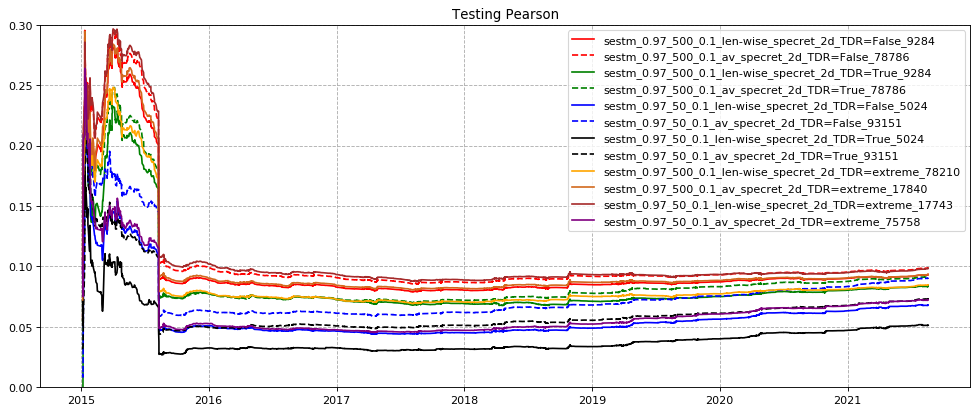

In [36]:
fig = plt.figure(figsize=(15, 6), dpi=80); ax = fig.add_subplot()
ax.xaxis.set_major_locator(mdates.YearLocator());  ax.set_title('Testing Pearson')
fmts = ['r','r--','g','g--','b','b--','k','k--','orange','chocolate','brown','purple']
for track_num in range(0,12):
    track_data = eval('track_{Tn}'.format(Tn=track_num)); fmt = fmts[track_num]
    ax.plot(track_data['date'],track_data['corr'],fmt,label=ts.iloc[track_num]['identifier'])
ax.set_ylim(0,0.3); plt.grid(linestyle='--'); plt.legend()
plt.savefig('D:/michael/full_version_data/img/test_data_sestm_corr_rolling_pearson.png'); plt.show()

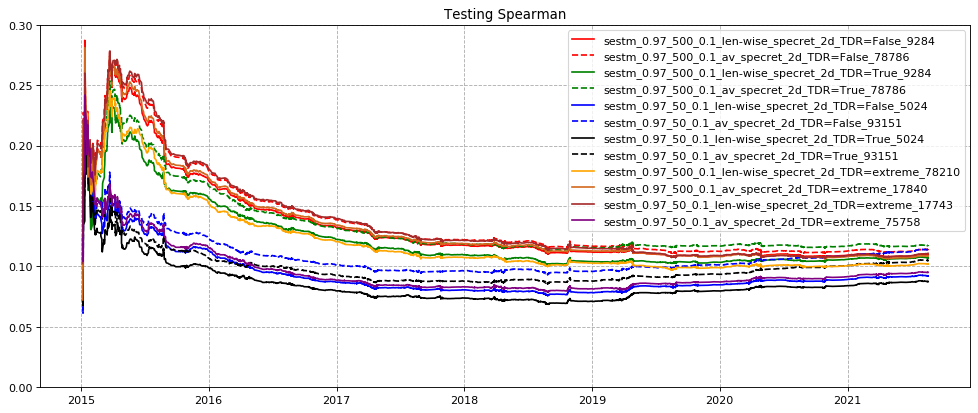

In [37]:
fig = plt.figure(figsize=(15, 6), dpi=80); ax = fig.add_subplot()
ax.xaxis.set_major_locator(mdates.YearLocator());  ax.set_title('Testing Spearman')
fmts = ['r','r--','g','g--','b','b--','k','k--','orange','chocolate','brown','purple']
for track_num in range(0,12):
    track_data = eval('track_{Tn}'.format(Tn=track_num)); fmt = fmts[track_num]
    ax.plot(track_data['date'],track_data['corr_spearman'],fmt,label=ts.iloc[track_num]['identifier'])
ax.set_ylim(0,0.3); plt.grid(linestyle='--'); plt.legend()
plt.savefig('D:/michael/full_version_data/img/test_data_sestm_corr_rolling_spearman.png'); plt.show()

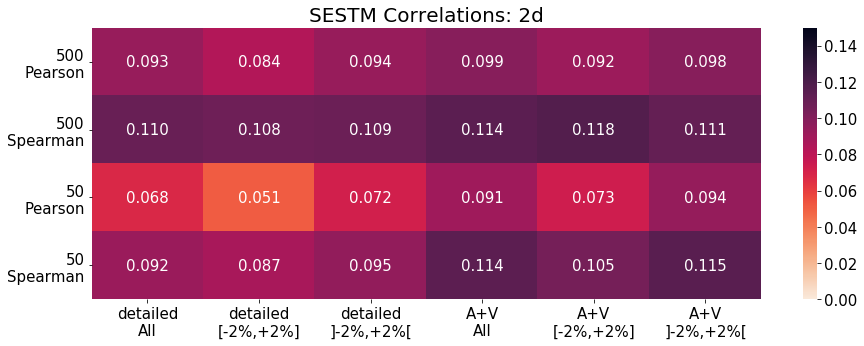

In [45]:
import seaborn as sns; from matplotlib import rc
hm_cols = ['detailed\nAll','detailed\n[-2%,+2%]','detailed\n]-2%,+2%[','A+V\nAll','A+V\n[-2%,+2%]','A+V\n]-2%,+2%[']
hm = pd.DataFrame(columns=hm_cols)
for awn in [500,50]:
    td = ts.loc[ts.alpha_word_num==awn]; rdp = []; rds = []
    for pu in ['len-wise','av']:
        for tdr in ['False','True','extreme']:
            rdp.append(td.loc[(td['pos_used'] == pu) & (td['train_data_retrict'] == tdr)].iloc[0]['test_corr'])
            rds.append(td.loc[(td['pos_used'] == pu) & (td['train_data_retrict'] == tdr)].iloc[0]['test_corr_spearman'])
    hm = hm.append(pd.DataFrame([rdp], columns=hm_cols, index=[str(awn)+'\nPearson']))
    hm = hm.append(pd.DataFrame([rds], columns=hm_cols, index=[str(awn)+'\nSpearman']))
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(hm, annot=True, cmap='rocket_r', ax=ax, fmt='.3f', vmin=0, vmax=0.15, annot_kws={"size":15})
plt.title('SESTM Correlations: 2d', size=20)
rc('xtick', labelsize=15) ; rc('ytick', labelsize=15)
plt.savefig('D:/michael/full_version_data/img/test_data_sestm_corr_heatmap_2d.png')
plt.show()

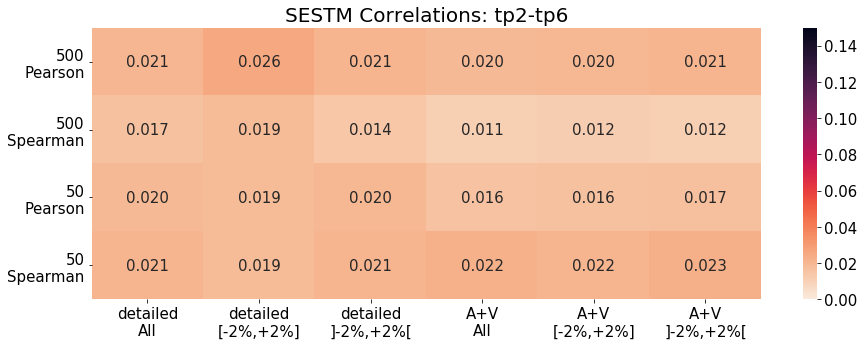

In [46]:
hm = pd.DataFrame(columns=hm_cols)
for awn in [500,50]:
    td = ts.loc[ts.alpha_word_num==awn]; rdp = []; rds = []
    for pu in ['len-wise','av']:
        for tdr in ['False','True','extreme']:
            rdp.append(td.loc[(td['pos_used'] == pu) & (td['train_data_retrict'] == tdr)].iloc[0]['test_corr_tp2-tp6'])
            rds.append(td.loc[(td['pos_used'] == pu) & (td['train_data_retrict'] == tdr)].iloc[0]['test_corr_spearman_tp2-tp6'])
    hm = hm.append(pd.DataFrame([rdp], columns=hm_cols, index=[str(awn)+'\nPearson']))
    hm = hm.append(pd.DataFrame([rds], columns=hm_cols, index=[str(awn)+'\nSpearman']))
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(hm, annot=True, cmap='rocket_r', ax=ax, fmt='.3f', vmin=0, vmax=0.15, annot_kws={"size":15})
plt.title('SESTM Correlations: tp2-tp6', size=20)
rc('xtick', labelsize=15) ; rc('ytick', labelsize=15)
plt.savefig('D:/michael/full_version_data/img/test_data_sestm_corr_heatmap_tp2-tp6.png')
plt.show()

## Combine All Sentiment

In [384]:
for ind in range(0,8):
    identifier = ts.iloc[ind]['identifier']
    sestm_scores = pd.read_csv('D:/michael/full_version_data/testing_results/test_data_{Ti}.csv'.format(Ti=identifier))[['ID',identifier]]
    test_data[identifier] = list(sestm_scores[identifier])

In [396]:
test_data.head(3)

,ID,SecuCode,date,specret,specret_2d,specret_tp2-tp6,jieba_content,sestm_0.97_500_0.1_len-wise_specret_2d_TDR=False_9284,sestm_0.97_500_0.1_av_specret_2d_TDR=False_78786,sestm_0.97_500_0.1_len-wise_specret_2d_TDR=True_9284,sestm_0.97_500_0.1_av_specret_2d_TDR=True_78786,sestm_0.97_50_0.1_len-wise_specret_2d_TDR=False_5024,sestm_0.97_50_0.1_av_specret_2d_TDR=False_93151,sestm_0.97_50_0.1_len-wise_specret_2d_TDR=True_5024,sestm_0.97_50_0.1_av_specret_2d_TDR=True_93151
181035,672010,600315,2015-01-05,0.017743,0.044812,0.015762,"[上海ns, 家化j, 股价n, 进入v, 价值n, 投资vn, 区域n, 出售vn, 天江...",0.503575,0.507305,0.504743,0.504938,0.543901,0.524445,0.535228,0.521174
181132,672362,600585,2015-01-05,-0.019222,-0.050626,0.037241,"[海螺n, 水泥n, Ax, 有望v, 受益v, 国企改革j, 一路m, 一带n, 估值n,...",0.502629,0.503616,0.500129,0.500613,0.500000,0.507452,0.500000,0.505597
181125,672353,002480,2015-01-05,-0.032496,-0.073719,-0.007047,"[新筑n, 股份n, 拟v, 收购v, 超级b, 电容器n, 龙头n, 掘金n, 城市ns,...",0.518296,0.513347,0.513162,0.504180,0.500000,0.512123,0.500000,0.505595


In [397]:
test_data.to_parquet('D:/michael/full_version_data/data_sestm_scores.parquet.gzip')

## Plots

In [47]:
identifier_num = 3

In [48]:
identifier = ts.iloc[identifier_num]['identifier']; print(identifier); ret_col = 'specret_2d'
sestm_scores = pd.read_csv('D:/michael/full_version_data/testing_results/test_data_{Ti}.csv'.format(Ti=identifier))[['ID',identifier]]
bp_df = test_data.copy(); bp_df[identifier] = list(sestm_scores[identifier])

sestm_0.97_500_0.1_av_specret_2d_TDR=True_78786


In [49]:
bp_df.sort_values(by = [identifier], ascending=False).head(3)

,ID,SecuCode,date,specret,specret_2d,specret_tp2-tp6,jieba_content,sestm_0.97_500_0.1_av_specret_2d_TDR=True_78786
412984,1220403,002353,2019-12-23,0.023889,0.040173,0.009578,"[杰瑞nr, 股份公司n, 深度ns, 报告n, 之二r, 电驱n, 压裂v, 北美ns, ...",0.559625
390860,1183118,600887,2019-08-07,0.001723,-0.012458,-0.020053,"[伊利nz, 股份n, 潮起潮落l, 千亿m, 股权n, 激励v, 保v, 业绩n, x,...",0.541220
411317,1214406,002353,2019-11-19,-0.007064,-0.004664,0.041414,"[杰瑞nr, 股份n, 创新v, 驱动vn, 发展vn, 大功率n, 涡轮n, 压裂v, 成...",0.537183


Text(0.5, 1.0, 'Testing')

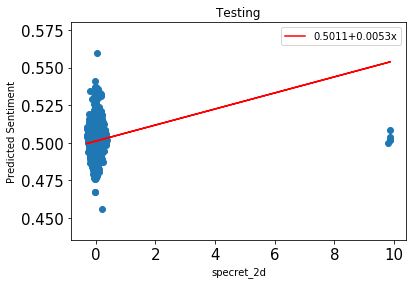

In [50]:
plt.scatter(bp_df[ret_col],bp_df[identifier])
m,b = np.polyfit(bp_df[ret_col],bp_df[identifier],1)
plt.plot(bp_df[ret_col], m*bp_df[ret_col]+b,\
         color='r', label=str(round(b,4))+'+'+str(round(m,4))+'x')
#plt.xlim(-0.5,0.5)
plt.legend()
plt.xlabel(ret_col); plt.ylabel('Predicted Sentiment')
plt.title('Testing')

Text(0.5, 1.0, 'Testing')

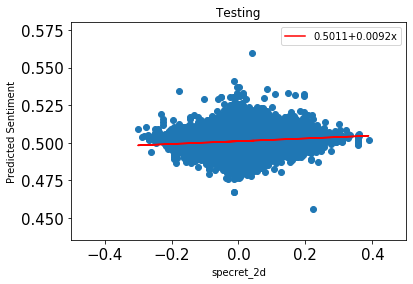

In [51]:
bp_df2 = bp_df.loc[bp_df.specret_2d<1]
plt.scatter(bp_df2[ret_col],bp_df2[identifier])
m,b = np.polyfit(bp_df2[ret_col],bp_df2[identifier],1)
plt.plot(bp_df2[ret_col], m*bp_df2[ret_col]+b,\
         color='r', label=str(round(b,4))+'+'+str(round(m,4))+'x')
plt.xlim(-0.5,0.5)
plt.legend()
plt.xlabel(ret_col); plt.ylabel('Predicted Sentiment')
plt.title('Testing')

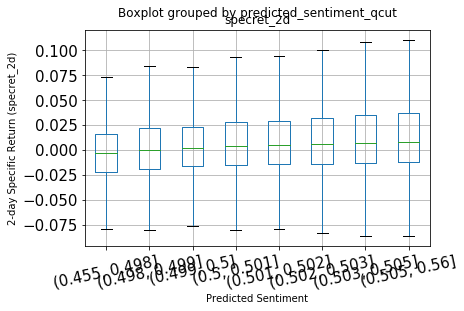

In [52]:
bp_df['predicted_sentiment_qcut'] = pd.qcut(bp_df[identifier],q=8)
bp_df.boxplot(column=[ret_col], by='predicted_sentiment_qcut', showfliers=False)
plt.xlabel('Predicted Sentiment'); plt.ylabel('2-day Specific Return (specret_2d)')
plt.xticks(rotation=12); rc('xtick', labelsize=10) ; rc('ytick', labelsize=10)
plt.savefig('D:/michael/full_version_data/img/qcut_boxplot_{Ti}.png'.format(Ti=identifier))
plt.show()

In [53]:
bp_df.groupby(['predicted_sentiment_qcut'])[['specret','specret_2d','specret_tp2-tp6',identifier]].mean()

,specret,specret_2d,specret_tp2-tp6,sestm_0.97_500_0.1_av_specret_2d_TDR=True_78786
predicted_sentiment_qcut,,,,
"(0.455, 0.498]",-0.001109,-0.001836,-0.000965,0.495226
"(0.498, 0.499]",0.001683,0.002776,-0.000260,0.498469
"(0.499, 0.5]",0.003145,0.005509,0.000008,0.499808
"(0.5, 0.501]",0.005186,0.008683,0.000888,0.500736
"(0.501, 0.502]",0.006693,0.010693,0.001540,0.501657
"(0.502, 0.503]",0.007048,0.011476,0.001533,0.502612
"(0.503, 0.505]",0.009098,0.014449,0.001945,0.503820
"(0.505, 0.56]",0.010254,0.016160,0.001429,0.506762


In [54]:
bp_df.groupby(['predicted_sentiment_qcut'])[['specret','specret_2d','specret_tp2-tp6',identifier]].median()

,specret,specret_2d,specret_tp2-tp6,sestm_0.97_500_0.1_av_specret_2d_TDR=True_78786
predicted_sentiment_qcut,,,,
"(0.455, 0.498]",-0.002216,-0.003481,-0.004457,0.495872
"(0.498, 0.499]",-0.000517,-0.000173,-0.003159,0.498516
"(0.499, 0.5]",0.000360,0.001577,-0.003258,0.499873
"(0.5, 0.501]",0.001575,0.003763,-0.002407,0.500746
"(0.501, 0.502]",0.002212,0.004959,-0.001783,0.501664
"(0.502, 0.503]",0.002325,0.005573,-0.003035,0.502602
"(0.503, 0.505]",0.003399,0.007100,-0.002379,0.503788
"(0.505, 0.56]",0.003924,0.007897,-0.003012,0.506035


In [55]:
bp_df[['specret_2d',identifier]].corr(method='spearman')

,specret_2d,sestm_0.97_500_0.1_av_specret_2d_TDR=True_78786
specret_2d,1.000000,0.117626
sestm_0.97_500_0.1_av_specret_2d_TDR=True_78786,0.117626,1.000000


### DRAFTS: Previous Result
```Please ignore codes starting from this line.```

In [ ]:
test_words_hash, test_pos_words, test_neg_words, test_corr, test_corr_spearman\
= testing_model(train_data.copy(), test_data.copy(), alpha_word_num = 500, pos_used='len-wise',\
                return_col='specret_2d', train_data_restrict=True)
pd.DataFrame([[test_words_hash, test_pos_words, test_neg_words, test_corr, test_corr_spearman]],\
             columns=['test_words_hash','test_pos_words','test_neg_words','test_corr','test_corr_spearman'])\
.to_csv('D:/michael/testing_1101/500_len-wise_specret_2d_TDR=True.csv')

In [ ]:
track = pd.read_csv('D:/michael/testing_1101/track_corr_43029_0.97_500_0.1_len-wise_specret_2d_TDR=True.csv',index_col=1)
track[['corr','corr_spearman']].plot()

In [ ]:
data = pd.read_parquet('D:/michael/testing_1101/test_data_43029_0.97_500_0.1_len-wise_specret_2d_TDR=True.parquet.gzip')

In [ ]:
test_data['predicted_sentiment_qcut'] = pd.qcut(data['predicted_sentiment'], 8)

### Return := Rank in [t+2,t+6]

In [ ]:
test_words_hash, test_pos_words, test_neg_words, test_corr, test_corr_spearman\
= testing_model(train_data.copy(), test_data.copy(), alpha_word_num = 500, pos_used='len-wise',\
                return_col='specret_tp2-tp6', train_data_restrict=True)
pd.DataFrame([[test_words_hash, test_pos_words, test_neg_words, test_corr, test_corr_spearman]],\
             columns=['test_words_hash','test_pos_words','test_neg_words','test_corr','test_corr_spearman'])\
.to_csv('D:/michael/testing_1101/500_len-wise_specret_tp2-tp6_TDR=True.csv')

In [ ]:
testing_params = [[0.97,50,0.1],[0.97,500,0.1]]

In [ ]:
LAMBDA = optimal_lambda

In [ ]:
start_time = dt.datetime.now(); print(start_time)
track_corr = pd.DataFrame(columns=['date','corr','adj_corr'])
predicted_sentiment = []; rolling_corr = None; rolling_adjcorr = None; test_date = None
for i in range(0, len(test_data)):
    clear_output(wait=True)
    print('Progress:\t{Count}/{Total} ({Pct}%)\t(Lambda={Lamb})'\
          .format(Count=i+1,Total=len(test_data),Pct=round((i+1)/len(test_data)*100,2),Lamb=LAMBDA))
    if not i%100:
        test_date = test_data.iloc[i].date
    print('Loading Data:\t',test_date)
    time_now = dt.datetime.now(); print('Elasped:\t',time_now - start_time)
    print('Est. Left:\t',(time_now - start_time)/(i+1)*(len(test_data)-i-1))
    print('ETA:\t\t',time_now+(time_now - start_time)/(i+1)*(len(test_data)-i-1))
    optimal_p = fminbound(lambda p: -1*likelihood_func(p, O, len(filtered_words), D_test[i], LAMBDA), 0, 1)
    predicted_sentiment.append(optimal_p)
    if i>1 and not i%100:
        test_data_segment = test_data[0:i+1]
        test_data_segment['predicted_sentiment'] = predicted_sentiment
        rolling_corr = test_data_segment[['specret_2d','predicted_sentiment']].corr().iloc[0]['predicted_sentiment']
        rolling_adjcorr = test_data_segment.loc[test_data_segment['specret_2d']<0.4]\
        [['specret_2d','predicted_sentiment']].corr().iloc[0]['predicted_sentiment']
        track_corr = track_corr.append(pd.DataFrame([[test_date,rolling_corr,rolling_adjcorr]],\
                                                    columns=['date','corr','adj_corr']))
    print('Rolling Corr:\t',rolling_corr); print('Roll AdjCorr:\t',rolling_adjcorr)
test_data_segment = test_data[0:len(test_data)]
test_data_segment['predicted_sentiment'] = predicted_sentiment
print('-'*45); print('Lambda:\t\t',LAMBDA)
print('Correlation:\t',test_data_segment[['specret_2d','predicted_sentiment']].corr().iloc[0]['predicted_sentiment'])
print('Adj Corr:\t',test_data_segment.loc[test_data_segment['specret_2d']<0.4]\
      [['specret_2d','predicted_sentiment']].corr().iloc[0]['predicted_sentiment'])
test_data_segment.to_parquet('D:/michael/testing_lambda-{Lamb}_data-{Stt}-{End}.parquet.gzip'\
                             .format(Lamb=LAMBDA,Stt=0,End=len(test_data)))
track_corr.to_csv('D:/michael/testing_track_corr_lambda-{Lamb}_data-{Stt}-{End}.csv'\
                             .format(Lamb=LAMBDA,Stt=0,End=len(test_data)))

In [ ]:
from matplotlib.pyplot import figure

In [ ]:
LAMBDA = optimal_lambda
plt.rc('xtick',labelsize=8)
figure(figsize=(7, 5), dpi=80)
corr_record = pd.read_csv('D:/michael/testing_track_corr_lambda-{Lamb}_data-{Stt}-{End}.csv'\
                             .format(Lamb=LAMBDA,Stt=0,End=len(test_data)))
corr_record.index=corr_record.date
corr_record['adj_corr'].plot(label='adj_corr, lambda='+str(LAMBDA),color=colors[color_index],linestyle='-')
corr_record['corr'].plot(label='corr, lambda='+str(LAMBDA),color=colors[color_index],linestyle='--')
plt.title('Testing Correlation, Train-Test Watershed = 2015 Head')
plt.xlabel('Rolling End Date'); plt.ylabel('Rolling Correlation')
plt.legend(); plt.savefig('D:/michael/img_output/testing_corr_2015')
plt.show()

In [ ]:
LAMBDA = optimal_lambda; starting_index = 0; test_data_used = len(test_data)
test_data_segment = pd.read_parquet('D:/michael/testing_lambda-{Lamb}_data-{Stt}-{End}.parquet.gzip'\
                             .format(Lamb=LAMBDA,Stt=starting_index,End=test_data_used))

test_data_segment = test_data[:test_data_used]

test_data_segment['predicted_sentiment'] = predicted_sentiment

In [ ]:
test_data_segment.sort_values(by = ['predicted_sentiment'], ascending=False).head(10)

In [ ]:
test_data_segment.loc[test_data_segment['specret_2d']>=0.4]

In [ ]:
tds_new = test_data_segment.loc[test_data_segment['specret_2d']<0.4]

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(tds_new['specret_2d'],tds_new.predicted_sentiment)
m,b = np.polyfit(tds_new['specret_2d'],tds_new.predicted_sentiment,1)
plt.plot(tds_new['specret_2d'], m*tds_new['specret_2d']+b,\
         color='r', label=str(round(b,4))+'+'+str(round(m,4))+'x')
plt.xlim(-0.5,0.5)
plt.legend()
plt.xlabel('SpecRet 2d'); plt.ylabel('Predicted Sentiment')
plt.title('Testing')
plt.savefig('testing.png')

In [ ]:
tds_new[['specret_2d','predicted_sentiment']].corr()

In [ ]:
tds_new['specret_2d_round'] = tds_new['specret_2d'].map(lambda x: round(x/0.05)*0.05)
tds_new['predicted_sentiment_round'] = tds_new['predicted_sentiment'].map(lambda x: round(x/0.01)*0.01)
tds_new['specret_2d_qcut'] = pd.qcut(tds_new['specret_2d'],q=8)
tds_new['predicted_sentiment_qcut'] = pd.qcut(tds_new['predicted_sentiment'],q=8)

In [ ]:
tds_new.groupby('specret_2d_qcut').count()

In [ ]:
tds2 = tds_new
tds2.boxplot(column=['predicted_sentiment'], by='specret_2d_qcut', showfliers=False)
#tds2.boxplot(column=['predicted_sentiment'], by='specret_2d_round', showfliers=False)

In [ ]:
tds2 = tds_new
tds2.boxplot(column=['specret_2d'], by='predicted_sentiment_qcut', showfliers=False)
#tds2.boxplot(column=['specret_2d'], by='predicted_sentiment_round', showfliers=False)

### Trying Spearman's Correlation

In [ ]:
def get_training_corr_spearman(LAMBDA,frc):
    global num_iter; num_iter+=1; predicted_sentiment = []; rolling_corr = None; train_date = None
    track_corr = pd.DataFrame(columns=['date','corr','adj_corr']); start_time = dt.datetime.now()
    train_data = train_data_all.sample(frac=frc, replace=False)
    for i in range(0, len(train_data)):
        clear_output(wait=True);print('CURRENT ITER:\tSeq={Seq},Lambda={Lamb}'.format(Seq=num_iter,Lamb=LAMBDA))
        print('Progress:\t{Count}/{Total} ({Pct}%)'\
              .format(Count=i+1,Total=len(train_data),Pct=round((i+1)/(len(train_data))*100,2)))
        if not i%100:
            train_date = train_data.iloc[i].date
        print('Loading Data:\t',train_date);time_now = dt.datetime.now(); print('Elasped:\t',time_now - start_time)
        print('Est. Left:\t',(time_now - start_time)/(i+1)*(len(train_data)-i-1))
        print('ETA:\t\t',time_now+(time_now - start_time)/(i+1)*(len(train_data)-i-1))
        optimal_p = fminbound(lambda p: -1*likelihood_func(p, O, len(filtered_words),\
                                                           D_train[train_data.iloc[i].name], LAMBDA), 0, 1)
        predicted_sentiment.append(optimal_p)
        if i>starting_index+1 and not i%100:
            train_data_segment = train_data[0:i+1]; train_data_segment['predicted_sentiment'] = predicted_sentiment
            rolling_corr = train_data_segment[['return','predicted_sentiment']].corr(method='spearman').iloc[0]['predicted_sentiment']
            track_corr = track_corr.append(pd.DataFrame([[train_date,rolling_corr]],columns=['date','corr']))
        print('Rolling Corr:\t',rolling_corr)
    train_data_segment = train_data; train_data_segment['predicted_sentiment'] = predicted_sentiment
    final_corr = train_data_segment[['return','predicted_sentiment']].corr(method='spearman').iloc[0]['predicted_sentiment']
    print('-'*45); print('Lambda:\t\t',LAMBDA); print('Correlation:\t',final_corr)
    train_data_segment.to_parquet('D:/michael/tuning_lambda/tuning_spearman_frac-{Frac}_lambda-{Lamb}.parquet.gzip'.format(Lamb=LAMBDA,Frac=frc))
    track_corr.to_csv('D:/michael/tuning_lambda/tuning_spearman_frac-{Frac}_lambda-{Lamb}.csv'.format(Lamb=LAMBDA,Frac=frc))
    return final_corr

In [ ]:
num_iter = 0; optimal_lambda_spearman = fminbound(lambda x: -1*get_training_corr_spearman(x,1), 0, 20)

In [ ]:
LAMBDA = optimal_lambda_spearman

In [ ]:
start_time = dt.datetime.now(); print(start_time)
track_corr = pd.DataFrame(columns=['date','corr','adj_corr'])
predicted_sentiment = []; rolling_corr = None; rolling_adjcorr = None; test_date = None
for i in range(0, len(test_data)):
    clear_output(wait=True)
    print('Progress:\t{Count}/{Total} ({Pct}%)\t(Lambda={Lamb})'\
          .format(Count=i+1,Total=len(test_data),Pct=round((i+1)/len(test_data)*100,2),Lamb=LAMBDA))
    if not i%100:
        test_date = test_data.iloc[i].date
    print('Loading Data:\t',test_date)
    time_now = dt.datetime.now(); print('Elasped:\t',time_now - start_time)
    print('Est. Left:\t',(time_now - start_time)/(i+1)*(len(test_data)-i-1))
    print('ETA:\t\t',time_now+(time_now - start_time)/(i+1)*(len(test_data)-i-1))
    optimal_p = fminbound(lambda p: -1*likelihood_func(p, O, len(filtered_words), D_test[i], LAMBDA), 0, 1)
    predicted_sentiment.append(optimal_p)
    if i>1 and not i%100:
        test_data_segment = test_data[0:i+1]
        test_data_segment['predicted_sentiment'] = predicted_sentiment
        rolling_corr = test_data_segment[['specret_2d','predicted_sentiment']].corr(method='spearman').iloc[0]['predicted_sentiment']
        rolling_adjcorr = test_data_segment.loc[test_data_segment['specret_2d']<0.4]\
        [['specret_2d','predicted_sentiment']].corr(method='spearman').iloc[0]['predicted_sentiment']
        track_corr = track_corr.append(pd.DataFrame([[test_date,rolling_corr,rolling_adjcorr]],\
                                                    columns=['date','corr','adj_corr']))
    print('Rolling Corr:\t',rolling_corr); print('Roll AdjCorr:\t',rolling_adjcorr)
test_data_segment = test_data[0:len(test_data)]
test_data_segment['predicted_sentiment'] = predicted_sentiment
print('-'*45); print('Lambda:\t\t',LAMBDA)
print('Correlation:\t',test_data_segment[['specret_2d','predicted_sentiment']].corr(method='spearman').iloc[0]['predicted_sentiment'])
print('Adj Corr:\t',test_data_segment.loc[test_data_segment['specret_2d']<0.4]\
      [['specret_2d','predicted_sentiment']].corr(method='spearman').iloc[0]['predicted_sentiment'])
test_data_segment.to_parquet('D:/michael/testing_spearman_lambda-{Lamb}_data-{Stt}-{End}.parquet.gzip'\
                             .format(Lamb=LAMBDA,Stt=0,End=len(test_data)))
track_corr.to_csv('D:/michael/testing_track_corr_spearman_lambda-{Lamb}_data-{Stt}-{End}.csv'\
                             .format(Lamb=LAMBDA,Stt=0,End=len(test_data)))

In [ ]:
LAMBDA = optimal_lambda_spearman
plt.rc('xtick',labelsize=8)
figure(figsize=(7, 5), dpi=80)
corr_record = pd.read_csv('D:/michael/testing_track_corr_spearman_lambda-{Lamb}_data-{Stt}-{End}.csv'\
                             .format(Lamb=LAMBDA,Stt=0,End=len(test_data)))
corr_record.index=corr_record.date
corr_record['adj_corr'].plot(label='spearman_adj_corr, lambda='+str(LAMBDA),color=colors[color_index],linestyle='-')
corr_record['corr'].plot(label='spearman_corr, lambda='+str(LAMBDA),color=colors[color_index],linestyle='--')

LAMBDA = optimal_lambda
corr_record = pd.read_csv('D:/michael/testing_track_corr_lambda-{Lamb}_data-{Stt}-{End}.csv'\
                             .format(Lamb=LAMBDA,Stt=0,End=len(test_data)))
corr_record.index=corr_record.date
corr_record['adj_corr'].plot(label='pearson_adj_corr, lambda='+str(LAMBDA),color='green',linestyle='-')
corr_record['corr'].plot(label='pearson_corr, lambda='+str(LAMBDA),color='green',linestyle='--')

plt.title('Testing Correlation, Train-Test Watershed = 2015 Head')
plt.xlabel('Rolling End Date'); plt.ylabel('Rolling Correlation')
plt.savefig('D:/michael/img_output/testing_corr_spearman_2015')
plt.legend(); plt.show()